In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
from matplotlib import pyplot as plt
from myBuilding import runMyBEM
from model.utils import *
import matplotlib.colors as mcolors
from epw import epw
import plotly.express as px

plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Specify Weather Data

In [22]:
# Function to generate sinusoidal data for temperature and radiation
def generate_sinusoidal_data(delt = 15, amplitude_temp=10, amplitude_radiation=250, length=24):
    length *= 3600  # Converting period from hours to seconds
    period = 24 * 3600
    time = np.arange(0, length, delt)  # Representing a day (24 hours) with a sinusoidal pattern
    temperature = amplitude_temp * np.sin(2 * np.pi * time / period) + 300  # Centered 
    radiation = amplitude_radiation * np.sin(2 * np.pi * time / period) + 250
    return time, temperature, radiation

# Generate sinusoidal data
times, Touts, rad = generate_sinusoidal_data(delt=5, length=96)


In [23]:
a = epw()
a.read("./energyPlus/weather/USA_CA_Sacramento.724835_TMY2.epw")
a.dataframe.index = pd.to_datetime(a.dataframe[['Year', 'Month', 'Day', 'Hour', 'Minute']])
display(a.dataframe.keys())
display(set(a.dataframe["Year"]))

Index(['Year', 'Month', 'Day', 'Hour', 'Minute',
       'Data Source and Uncertainty Flags', 'Dry Bulb Temperature',
       'Dew Point Temperature', 'Relative Humidity',
       'Atmospheric Station Pressure', 'Extraterrestrial Horizontal Radiation',
       'Extraterrestrial Direct Normal Radiation',
       'Horizontal Infrared Radiation Intensity',
       'Global Horizontal Radiation', 'Direct Normal Radiation',
       'Diffuse Horizontal Radiation', 'Global Horizontal Illuminance',
       'Direct Normal Illuminance', 'Diffuse Horizontal Illuminance',
       'Zenith Luminance', 'Wind Direction', 'Wind Speed', 'Total Sky Cover',
       'Opaque Sky Cover (used if Horizontal IR Intensity missing)',
       'Visibility', 'Ceiling Height', 'Present Weather Observation',
       'Present Weather Codes', 'Precipitable Water', 'Aerosol Optical Depth',
       'Snow Depth', 'Days Since Last Snowfall', 'Albedo',
       'Liquid Precipitation Depth', 'Liquid Precipitation Quantity'],
      dtype='obj

{1964, 1966, 1967, 1968, 1971, 1974, 1981, 1985, 1986, 1987}

In [24]:
data = a.dataframe[(a.dataframe["Month"]==8) & (a.dataframe["Day"] >= 29)]
data = data.resample("5s").interpolate()
fig = px.line(data, x = data.index, y = [
    "Direct Normal Radiation",
    "Dry Bulb Temperature",
    ])
fig.show()

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_55590/3134994359.py:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/opt/homebrew/Caskroom/miniconda/base/envs/pycascade/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# BEM Model

## Medium Wall

In [25]:
constructions  = pd.read_csv("energyPlus/ASHRAE_2005_HOF_Constructions.csv", index_col="Name")
materials = pd.read_csv("energyPlus/ASHRAE_2005_HOF_Materials.csv", index_col="Name")


def cleanMaterial(materialName, reverse = True):
    wallLayers = ["Outside_Layer", "Layer_2", "Layer_3", "Layer_4", "Layer_5"]
    if reverse:
        wallLayers = wallLayers[::-1]
    material_df = []
    for layer in wallLayers:
        material = constructions[layer][materialName]
        if isinstance(material, str):
            conductivity = materials["Conductivity"][material]
            if (conductivity > 10) == False: # filter out the materials with conductivity > 10 that mess up solver and basically transfer all heat
                material_df.append(materials.loc[material])
    return pd.DataFrame(material_df)

wallMaterial = cleanMaterial("Medium Exterior Wall")
partitionMaterial = cleanMaterial("Medium Partitions")
roofMaterial = cleanMaterial("Medium Roof/Ceiling")
floorMaterial = cleanMaterial("Medium Floor", reverse=False)
floorMaterial.loc["Soil"] = ["Material", np.nan, .5, 1.5, 2800, 850, np.nan]


display(wallMaterial, partitionMaterial, roofMaterial, floorMaterial)

# plt.figure()
# for i, material in enumerate([wallMaterial, partitionMaterial, roofMaterial, floorMaterial]):
#     sns.barplot(x = i, y = material["Deth"], hue = material["Conductivity"])

key     Roughness  Thickness  \
G01a 19mm gypsum board                Material  MediumSmooth     0.0190   
F04 Wall air space resistance  Material:AirGap           NaN        NaN   
I02 50mm insulation board             Material   MediumRough     0.0508   
M01 100mm brick                       Material   MediumRough     0.1016   

                               Conductivity  Density  Specific_Heat  \
G01a 19mm gypsum board                 0.16    800.0         1090.0   
F04 Wall air space resistance           NaN      NaN            NaN   
I02 50mm insulation board              0.03     43.0         1210.0   
M01 100mm brick                        0.89   1920.0          790.0   

                               Thermal_Resistance  
G01a 19mm gypsum board                        NaN  
F04 Wall air space resistance                0.15  
I02 50mm insulation board                     NaN  
M01 100mm brick                               NaN

key     Roughness  Thickness  \
G01a 19mm gypsum board                Material  MediumSmooth      0.019   
F04 Wall air space resistance  Material:AirGap           NaN        NaN   
G01a 19mm gypsum board                Material  MediumSmooth      0.019   

                               Conductivity  Density  Specific_Heat  \
G01a 19mm gypsum board                 0.16    800.0         1090.0   
F04 Wall air space resistance           NaN      NaN            NaN   
G01a 19mm gypsum board                 0.16    800.0         1090.0   

                               Thermal_Resistance  
G01a 19mm gypsum board                        NaN  
F04 Wall air space resistance                0.15  
G01a 19mm gypsum board                        NaN

key     Roughness  Thickness  \
F16 Acoustic tile                        Material  MediumSmooth     0.0191   
F05 Ceiling air space resistance  Material:AirGap           NaN        NaN   
M14a 100mm heavyweight concrete          Material   MediumRough     0.1016   

                                  Conductivity  Density  Specific_Heat  \
F16 Acoustic tile                         0.06    368.0          590.0   
F05 Ceiling air space resistance           NaN      NaN            NaN   
M14a 100mm heavyweight concrete           1.95   2240.0          900.0   

                                  Thermal_Resistance  
F16 Acoustic tile                                NaN  
F05 Ceiling air space resistance                0.18  
M14a 100mm heavyweight concrete                  NaN

key     Roughness  Thickness  \
F16 Acoustic tile                        Material  MediumSmooth     0.0191   
F05 Ceiling air space resistance  Material:AirGap           NaN        NaN   
M14a 100mm heavyweight concrete          Material   MediumRough     0.1016   
Soil                                     Material           NaN     0.5000   

                                  Conductivity  Density  Specific_Heat  \
F16 Acoustic tile                         0.06    368.0          590.0   
F05 Ceiling air space resistance           NaN      NaN            NaN   
M14a 100mm heavyweight concrete           1.95   2240.0          900.0   
Soil                                      1.50   2800.0          850.0   

                                  Thermal_Resistance  
F16 Acoustic tile                                NaN  
F05 Ceiling air space resistance                0.18  
M14a 100mm heavyweight concrete                  NaN  
Soil                                             NaN

/Users/nicholasbachand/Documents/Research/InteriorModeling/myBuilding.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



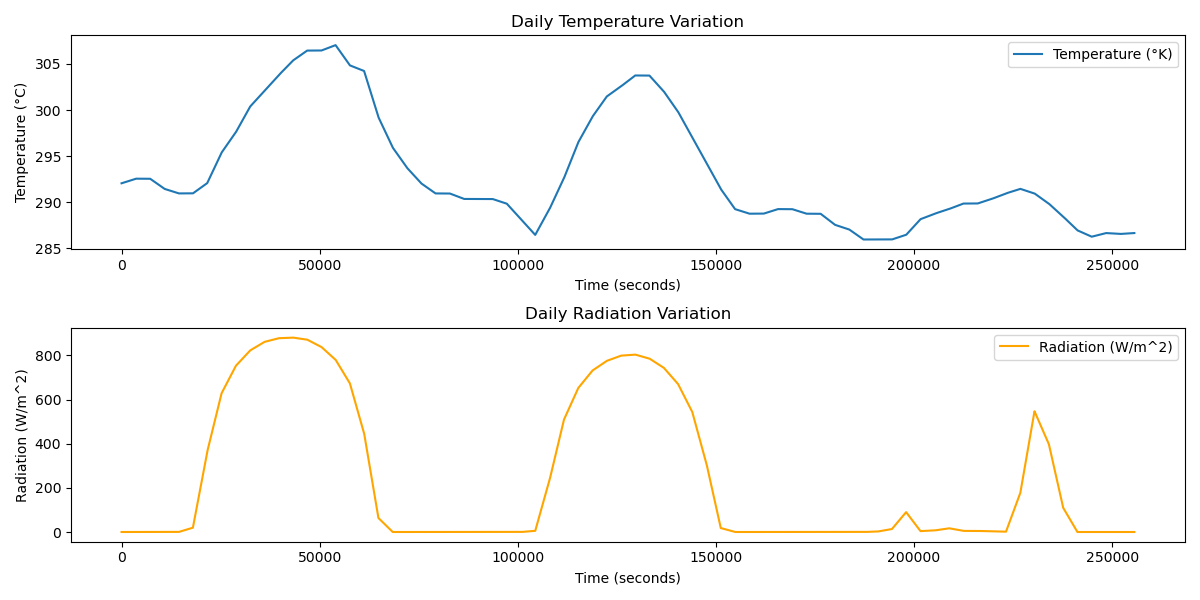

/Users/nicholasbachand/Documents/Research/InteriorModeling/myBuilding.py:72: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/nicholasbachand/Documents/Research/InteriorModeling/myBuilding.py:73: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



maximum time step: 6.8742
maximum time step: 6.8742
maximum time step: 31.00625999999999
maximum time step: 26.201556
maximum time step: 134.74155599999997
maximum time step: 6.8742
maximum time step: 6.8742
maximum time step: 31.00625999999999
maximum time step: 26.201556
maximum time step: 134.74155599999997
maximum time step: 6.8742
maximum time step: 6.8742
maximum time step: 31.00625999999999
maximum time step: 26.201556
maximum time step: 134.74155599999997
maximum time step: 31.00625999999999
maximum time step: 26.201556
maximum time step: 134.74155599999997


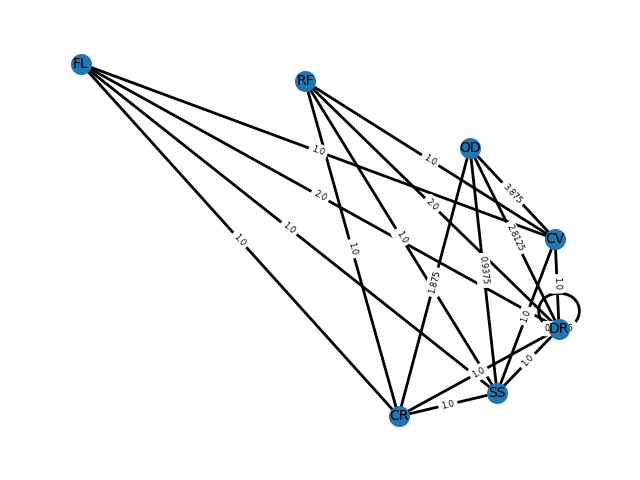

In [26]:
build_sim, interiorRooms = runMyBEM(
    data,
    wallMaterial,
    partitionMaterial,
    roofMaterial,
    floorMaterial,
    makePlots=True
)

Ventilation at 18.7 hours (time: 18.7)
Ventilation at 40.0 hours (time: 16.0)


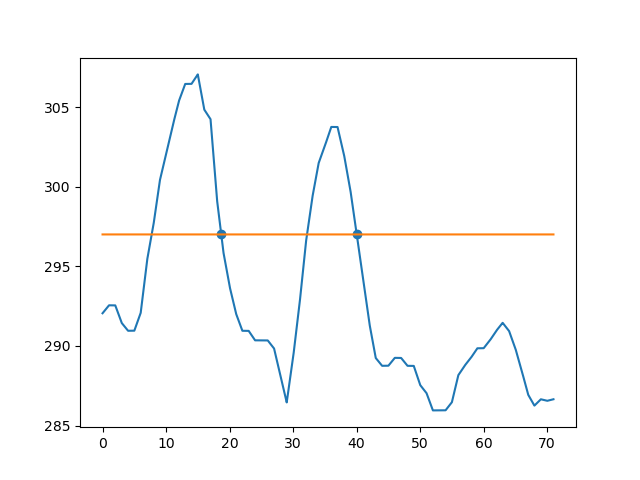

In [39]:
Tvent = 297
hVent = []
iVent = []
T_old = Tvent
for i, T in enumerate(build_sim.Tout):
    if T_old > Tvent and T <= Tvent:
        hVent.append(build_sim.hours[i])
        iVent.append(i)
        print(f"Ventilation at {round(hVent[-1],1)} hours (time: {round(hVent[-1]%24, 1)})")
    T_old = T

plt.figure()
plt.plot(build_sim.hours, build_sim.Tout, label="Outdoor temperature")
plt.plot(build_sim.hours, Tvent*np.ones_like(build_sim.hours), label="Indoor temperature")
plt.scatter(hVent, [Tvent]*len(hVent), label="Ventilation Times")

<Figure size 640x480 with 0 Axes>

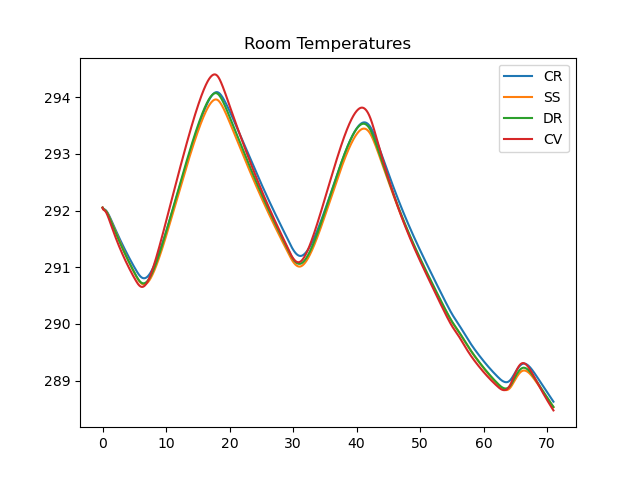

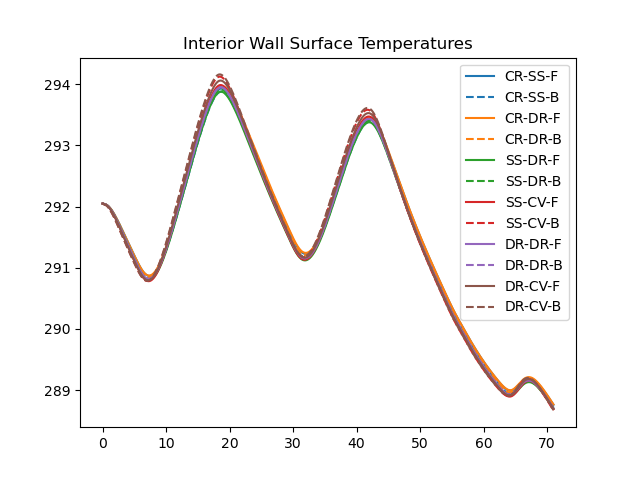

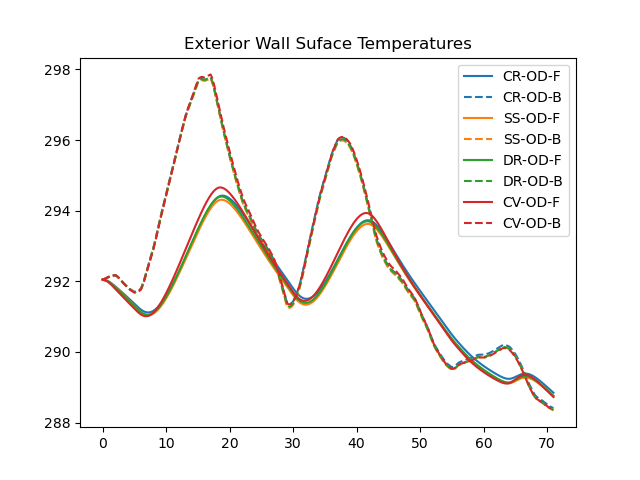

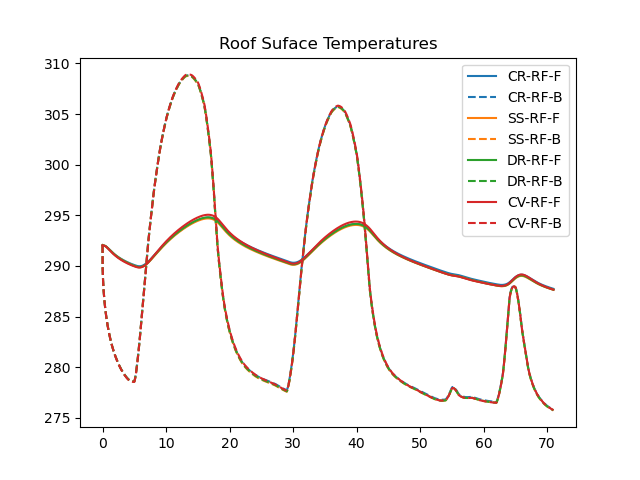

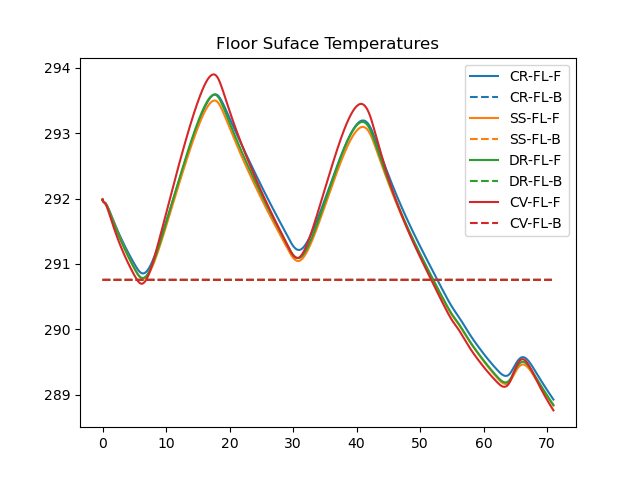

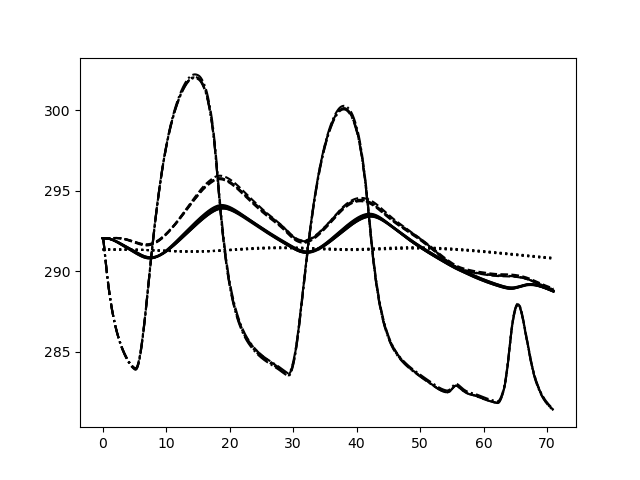

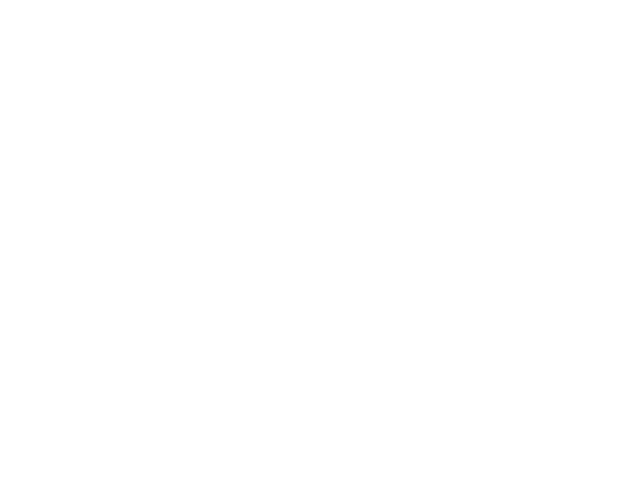

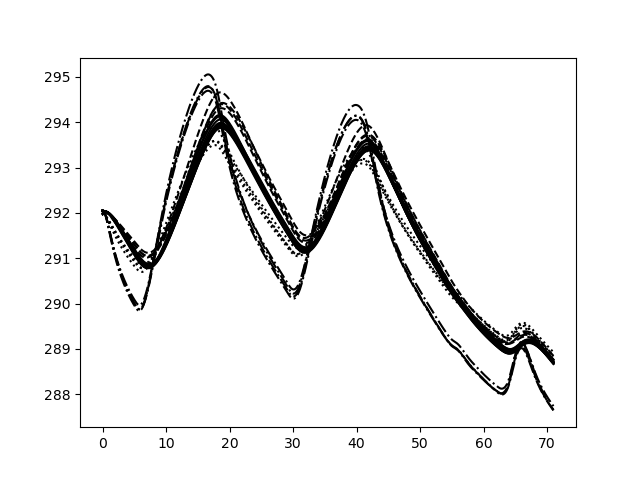

In [28]:
plt.figure()
for n, d in build_sim.bG.G.nodes(data=True):
    if n in interiorRooms:
        plt.plot(build_sim.hours, d['Tints'], label=n)
plt.legend()
plt.title("Room Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Interior Wall Surface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Exterior Wall Suface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Roof Suface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Floor Suface Temperatures")

plt.figure()
for i, j, d in build_sim.bG.G.edges(data=True):
    center = int(len(d['T_profs'][:, 0]) / 2)
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        lt = '-'
    elif d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        lt = '--'
    elif d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        lt = '-.'
    elif d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        lt = ':'
    plt.plot(build_sim.hours, d['T_profs'][center, :], color = 'k', linestyle = lt)
    # plt.legend()
plt.figure("Wall Center Temperatures")

plt.figure()
for i, j, d in build_sim.bG.G.edges(data=True):
    center = int(len(d['T_profs'][:, 0]) / 2)
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        lt = '-'
        plt.plot(build_sim.hours, d['T_profs'][-1, :], color = 'k', linestyle = lt)
    elif d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        lt = '--'
    elif d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        lt = '-.'
    elif d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        lt = ':'
    plt.plot(build_sim.hours, d['T_profs'][0, :], color = 'k', linestyle = lt)
    # plt.legend()
plt.figure("Wall Center Temperatures")

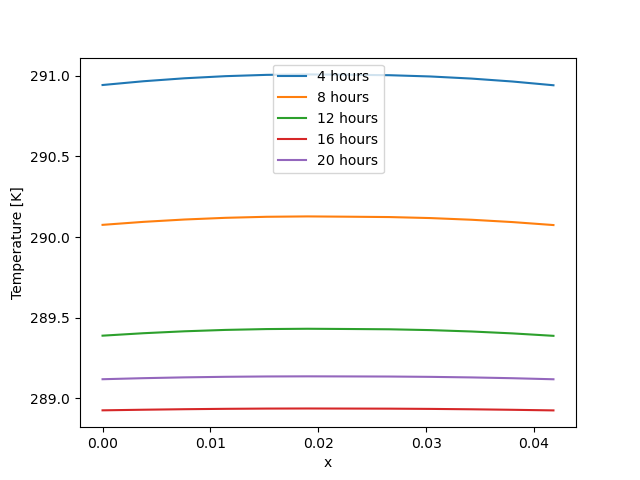

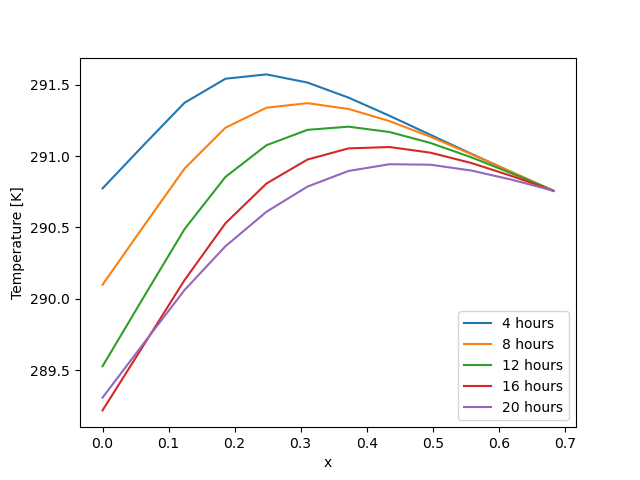

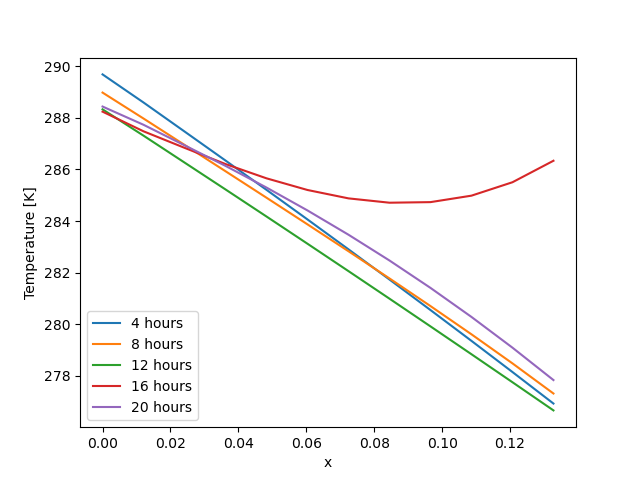

In [29]:
plt.figure()
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
wall = build_sim.bG.G.edges['DR', 'DR']['wall']
T_profs = build_sim.bG.G.edges['DR', 'DR']['T_profs']
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

plt.figure()
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
wall = build_sim.bG.G.edges['DR', 'FL']['wall']
T_profs = build_sim.bG.G.edges['DR', 'FL']['T_profs']
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

plt.figure()
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
wall = build_sim.bG.G.edges['DR', 'RF']['wall']
T_profs = build_sim.bG.G.edges['DR', 'RF']['T_profs']
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

'Average "ceiling - floor" temperature difference at ventilation time: 0.7726980667838035'

'Average "interior wall - floor" temperature difference at ventilation time: -0.4957910258574027'

'Average "exterior wall - floor" temperature difference at ventilation time: -0.11875279571312092'

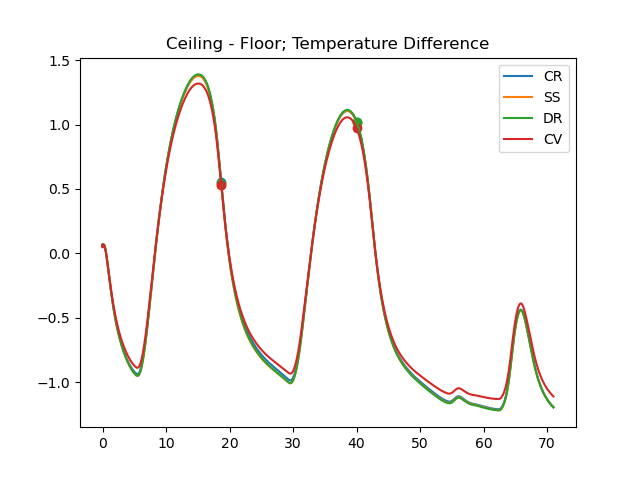

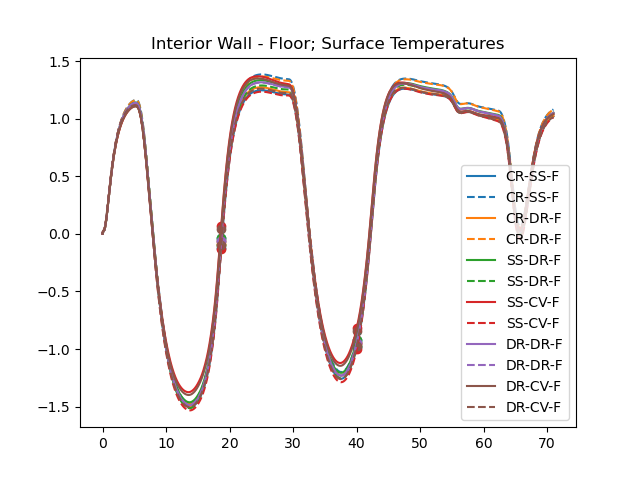

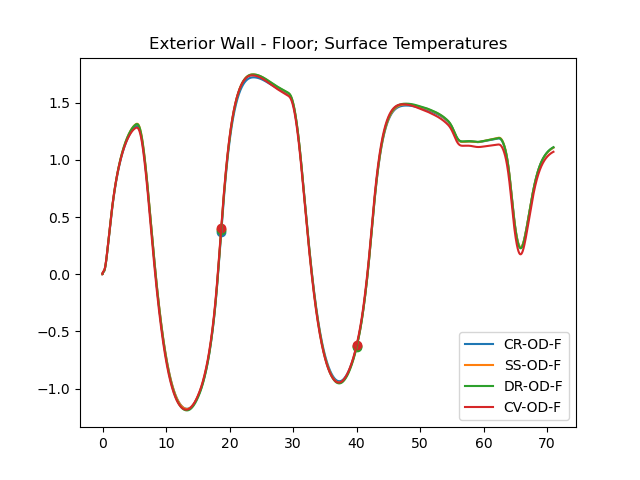

In [30]:
plt.figure()
delVent = []
for n, _ in build_sim.bG.G.nodes(data=True):
    if n in interiorRooms:
        ceiling_temp = build_sim.bG.G[n]["RF"]["T_profs"][0, :]
        floor_temp = build_sim.bG.G[n]["FL"]["T_profs"][0, :]
        diff = ceiling_temp - floor_temp
        plt.plot(build_sim.hours, diff, label=n)
        plt.scatter(hVent, diff[iVent])
        delVent.append(diff[iVent])
plt.legend()
plt.title("Ceiling - Floor; Temperature Difference")
display(f'Average "ceiling - floor" temperature difference at ventilation time: {np.mean(delVent)}')

plt.figure()
delVent = []
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        for side in range(2):
            floor_temp = build_sim.bG.G[[i, j][side]]["RF"]["T_profs"][0, :]
            diff = d['T_profs'][-side, :] - floor_temp
            plt.plot(build_sim.hours, diff, label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[side])
            plt.scatter(hVent, diff[iVent], color = colors[c])
            delVent.append(diff[iVent])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Interior Wall - Floor; Surface Temperatures")
display(f'Average "interior wall - floor" temperature difference at ventilation time: {np.mean(delVent)}')

plt.figure()
delVent = []
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        floor_temp = build_sim.bG.G[i]["RF"]["T_profs"][0, :]
        diff = d['T_profs'][0, :] - floor_temp
        plt.plot(build_sim.hours, diff, label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.scatter(hVent, diff[iVent], color = colors[c])
        delVent.append(diff[iVent])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Exterior Wall - Floor; Surface Temperatures")
display(f'Average "exterior wall - floor" temperature difference at ventilation time: {np.mean(delVent)}')

In [31]:
# plt.figure()
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].front, label='Calculated')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].front, label='Applied')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radECalc"].front, label='Calculated')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radEApplied"].front, label='Applied')
# plt.legend()
# # plt.ylim([-200, 25])
# plt.xlabel('hours')
# plt.ylabel('Radiation [W]')